### project set up
* copy folders from `ViT-pytorch` repo:
    * models
    * utils

In [1]:
import typing
import io
import os
import copy

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

from urllib.request import urlretrieve
import tarfile

from PIL import Image
from torchvision import transforms, datasets

from models.modeling import VisionTransformer, CONFIGS

### ViT model and ImageNet labels

Do I need imagenet labels?


In [2]:
os.makedirs("attention_data", exist_ok=True)
if not os.path.isfile("attention_data/ilsvrc2012_wordnet_lemmas.txt"):
    urlretrieve("https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt", "attention_data/ilsvrc2012_wordnet_lemmas.txt")
if not os.path.isfile("attention_data/ViT-B_16-224.npz"):
    urlretrieve("https://storage.googleapis.com/vit_models/imagenet21k+imagenet2012/ViT-B_16-224.npz", "attention_data/ViT-B_16-224.npz")

imagenet_labels = dict(enumerate(open('attention_data/ilsvrc2012_wordnet_lemmas.txt')))

## Setup IN9 dataset

In [3]:
# download and extract IN9 dataset described here https://arxiv.org/abs/2006.09994
os.makedirs("IN9", exist_ok=True)
if not os.path.isfile("IN9/backgrounds_challenge_data.tar.gz"):
    urlretrieve("https://github.com/MadryLab/backgrounds_challenge/releases/download/data/backgrounds_challenge_data.tar.gz", "IN9/backgrounds_challenge_data.tar.gz")

if not os.path.exists("IN9/bg_challenge/"):
    print(f"uncompressing tar file...")
    my_tar = tarfile.open('IN9/backgrounds_challenge_data.tar.gz')
    my_tar.extractall('IN9/') 
    my_tar.close()    
else:
    print(f"Dataset already uncompressed!")

Dataset already uncompressed!


In [283]:
# segmentation_sample = np.load("IN9/bg_challenge/fg_mask/val/00_dog/n02085620_16757.npy")
# image_sample = Image.open("IN9/bg_challenge/original/val/00_dog/n02085620_16757.JPEG").convert("RGB")
# segmentation_sample = np.load("IN9/bg_challenge/fg_mask/val/01_bird/n01514668_03936.npy")
# image_sample = Image.open("IN9/bg_challenge/original/val/01_bird/n01514668_03936.JPEG").convert("RGB")
segmentation_sample = np.load("IN9/bg_challenge/fg_mask/val/00_dog/n02088364_47125.npy")
image_sample = Image.open("IN9/bg_challenge/original/val/00_dog/n02088364_47125.JPEG").convert("RGB")
segmentation_sample = np.load("IN9/bg_challenge/fg_mask/val/01_bird/n01622779_16292.npy")
image_sample = Image.open("IN9/bg_challenge/original/val/01_bird/n01622779_16292.JPEG").convert("RGB")



In [284]:
bg_mask_image_sample = copy.deepcopy(np.array(image_sample))
bg_mask_image_sample[~segmentation_sample] = 0
bg_mask_image_sample[segmentation_sample] = 255

(224, 224)


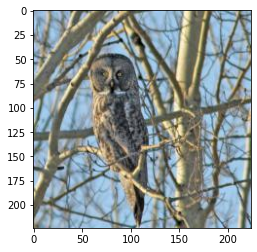

(224, 224, 3)


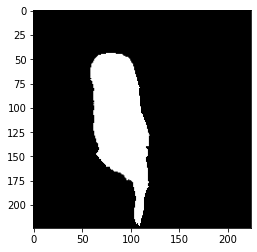

In [285]:
print(image_sample.size)
plt.imshow(image_sample)
plt.show()
print(bg_mask_image_sample.shape)
plt.imshow(bg_mask_image_sample)

In [286]:
np.min(bg_mask_image_sample), np.max(bg_mask_image_sample)

(0, 255)

In [287]:
transform = transforms.Compose(
    [transforms.Resize((224,224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

## Prepare Model

In [288]:
config = CONFIGS["ViT-B_16"]
model = VisionTransformer(config, num_classes=1000, zero_head=False, img_size=224, vis=True)
model.load_from(np.load("attention_data/ViT-B_16-224.npz"))
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

In [289]:
patch_size = config.patches["size"]
img_h, img_w = (224, 224)
n_patches = (img_h // patch_size[0]) * (img_w // patch_size[1])
n_patches

196

In [290]:
# total pixels original image
224*224

50176

In [291]:
# patch size x n_patches = total pixels
16*16*196

50176

In [292]:
14*14

196

### Explaining attention map shape

1. The image will be split into N patches of size (16,16) (in this ViT setting)
2. Linear projection of flattened patches (patch_embeddings), so each patch became an embedding of D size (768)
3. CLS token embedding is prepended (added in the begining) of all N x 768 embeddings
4. Position embeddings are added

For a 224x224 image there will be 196 patches, therefore the embedding layer is 196x768 (or 197x768 because of the CLS token)

**This is the input for the Transformer encoder**

1. The attention layer will get the attention map/weights of all 197 embeddings generating a 197x197 matrix.
**This is the attention map we are analyzing**



In [293]:
# test new outputs
logits, att_mat, activation = model(transform(image_sample).unsqueeze(0))

In [294]:
logits.shape

torch.Size([1, 1000])

In [295]:
len(att_mat)

12

In [296]:
len(activation)

12

In [297]:
print(activation[0].shape)
activation[0].squeeze().detach().numpy()

torch.Size([1, 197, 768])


array([[-9.5801525e-02, -5.8727764e-02, -9.5015353e-01, ...,
        -8.7505616e-03, -2.0590462e-03, -1.3526360e+00],
       [-1.8567717e-01, -7.2215557e-01,  1.3113590e+00, ...,
         7.8304321e-02,  1.1050322e+00, -3.1253740e-01],
       [ 4.4208014e-01,  1.9989544e-01,  7.7678818e-01, ...,
         7.8518558e-01, -1.4437784e-01,  3.7479001e-01],
       ...,
       [-2.4343823e-01, -4.0125209e-01, -1.4843769e-02, ...,
        -1.1221073e+00, -7.0865273e-01,  2.0975709e-02],
       [-1.1496160e+00,  9.5205760e-01, -1.6333210e-01, ...,
        -3.8094300e-01, -2.6318362e+00, -6.3882327e-01],
       [ 4.2241156e-02, -5.7244676e-01,  1.4688631e+00, ...,
        -1.9580683e+00,  1.7518067e-01, -6.5095717e-01]], dtype=float32)

In [298]:
print(activation[1].shape)
activation[1].squeeze().detach().numpy()

torch.Size([1, 197, 768])


array([[-0.31746396, -0.6262032 , -1.1927242 , ..., -0.300834  ,
         0.1385038 , -1.4697512 ],
       [-0.64428645, -1.6189792 ,  1.384887  , ...,  0.48597327,
         1.3109152 , -0.51401234],
       [-0.13670233, -1.0084097 ,  0.85011184, ..., -0.38788676,
         1.1856933 ,  0.56888026],
       ...,
       [-0.40872675, -1.2974377 , -0.36054447, ..., -0.94684446,
         0.4803276 ,  0.8191056 ],
       [-1.7289165 ,  0.12933886, -0.09012839, ..., -1.1185813 ,
        -0.7168244 , -0.40577984],
       [-0.88411844, -1.0941533 ,  0.3344748 , ..., -0.20319676,
         0.7961011 , -1.5227077 ]], dtype=float32)

In [299]:
# Move function to a separate file for readability

In [300]:
# def predict(x):
#     logits, att_mat = model(x.unsqueeze(0))
#     print([(att_.shape, type(att_)) for att_ in att_mat])
#     print(f"length of attention map list: {len(att_mat)}")

#     att_mat = torch.stack(att_mat)
#     print(att_mat.shape)
#     att_mat = att_mat.squeeze(1)
#     print(att_mat.shape)

#     # Average the attention weights across all heads.
#     att_mat = torch.mean(att_mat, dim=1)
#     print(att_mat.shape)
#     mean_att_mat = att_mat

#     # To account for residual connections, we add an identity matrix to the
#     # attention matrix and re-normalize the weights.
#     residual_att = torch.eye(att_mat.size(1))
#     aug_att_mat = att_mat + residual_att
#     aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

#     # Recursively multiply the weight matrices
#     joint_attentions = torch.zeros(aug_att_mat.size())
#     joint_attentions[0] = aug_att_mat[0]

#     for n in range(1, aug_att_mat.size(0)):
#         joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])

#     # Last layer attention map
#     v = joint_attentions[-1]
#     grid_size = int(np.sqrt(aug_att_mat.size(-1)))
#     print(aug_att_mat.shape)
#     print(grid_size)
#     last_layer = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
#     last_layer = cv2.resize(last_layer / last_layer.max(), (112,112))[..., np.newaxis]
    
#     #classification result
#     probs = torch.nn.Softmax(dim=-1)(logits)
#     top5 = torch.argsort(probs, dim=-1, descending=True)
#     clf_results = {}
#     for top_n in top5[0, :5].detach().numpy():    
#         clf_results[top_n] = float(probs[0, top_n].detach().numpy())
        
#     #all attention layers for visualization
#     all_att_layers = []
#     for v in aug_att_mat:
#         print(v.shape)
#         att_lyr = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
#         att_lyr = cv2.resize(att_lyr / att_lyr.max(), (112,112))#[..., np.newaxis]
#         all_att_layers.append(att_lyr)          
    
#     return clf_results, last_layer, all_att_layers, mean_att_mat

In [301]:
# clf_results, _, _, mean_map = predict(transform(image_sample))

In [302]:
mean_map = att_map
grid_size = int(np.sqrt(mean_map[:,1:,1:].size(-1)))
grid_size

14

In [303]:
if True:
    residual_att = torch.eye(mean_map.size(1))
    aug_mean_map = mean_map + residual_att
    aug_mean_map = aug_mean_map / aug_mean_map.sum(dim=-1).unsqueeze(-1)
    mean_map = aug_mean_map

In [304]:
mean_map = mean_map.detach().numpy()
mean_map.shape

(12, 197, 197)

In [305]:
last_layer_map = mean_map[-1,:,:]
last_layer_map.shape

(197, 197)

In [306]:
clf_layer_map = last_layer_map[0,1:]
clf_layer_map.shape

(196,)

In [307]:
clf_layer_map_img = clf_layer_map.reshape(grid_size, grid_size)

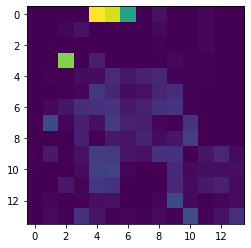

In [308]:
plt.imshow(clf_layer_map_img)

array([[8.0894555e-05, 1.7240766e-03, 1.4212415e-05, 1.0119134e-05,
        1.3123597e-05, 8.8204601e-05],
       [7.7655324e-04, 7.4130349e-04, 2.8735267e-03, 1.4655065e-03,
        2.0266781e-03, 2.6225911e-03],
       [3.6526867e-04, 3.7732872e-03, 2.4529332e-03, 7.5614947e-04,
        9.9581853e-04, 2.3667493e-03],
       [3.0036878e-03, 3.2264115e-03, 3.4722397e-03, 1.6139111e-03,
        2.0015198e-03, 3.0675661e-03],
       [1.9563844e-03, 9.1164908e-04, 3.8265521e-03, 1.9826291e-03,
        1.7132853e-03, 3.0206642e-04],
       [1.9200578e-03, 2.2621808e-04, 1.5136475e-03, 1.3261121e-03,
        2.2471386e-03, 7.6774880e-04]], dtype=float32)

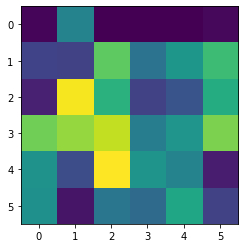

In [309]:
plt.imshow(clf_layer_map_img[3:9,3:9])
clf_layer_map_img[3:9,3:9]

array([[8.0894555e-05, 1.7240766e-03, 1.4212415e-05, 1.0119134e-05,
        1.3123597e-05, 8.8204601e-05],
       [7.7655324e-04, 7.4130349e-04, 2.8735267e-03, 1.4655065e-03,
        2.0266781e-03, 2.6225911e-03],
       [3.6526867e-04, 3.7732872e-03, 2.4529332e-03, 7.5614947e-04,
        9.9581853e-04, 2.3667493e-03],
       [3.0036878e-03, 3.2264115e-03, 3.4722397e-03, 1.6139111e-03,
        2.0015198e-03, 3.0675661e-03],
       [1.9563844e-03, 9.1164908e-04, 3.8265521e-03, 1.9826291e-03,
        1.7132853e-03, 3.0206642e-04],
       [1.9200578e-03, 2.2621808e-04, 1.5136475e-03, 1.3261121e-03,
        2.2471386e-03, 7.6774880e-04]], dtype=float32)

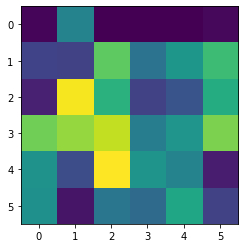

In [310]:
plt.imshow(clf_layer_map_img[3:9,3:9])
clf_layer_map_img[3:9,3:9]

In [311]:
def find_original_img_patch(vit_patch:int, original_img, grid_size:int=14, patch_size:int=16):
#     h_p, w_p = vit_patch
#     projection = original_img[h_p * patch_size:(h_p * patch_size)+patch_size, w_p * patch_size:(w_p * patch_size)+patch_size]
    col_p = vit_patch // grid_size
    row_p = vit_patch - (col_p * grid_size)
    y = row_p * patch_size
    width = patch_size
    x = col_p * patch_size
    height = patch_size
    projection = original_img[x:x+width, y:y+height]
    return projection, (x, x+width, y, y+height)

In [312]:
img = image_sample.resize((224,224))
img = np.array(img)
mask_img = bg_mask_image_sample
# mask_img = np.array(mask_img)

img_patch, coord = find_original_img_patch(97, img)
img_patch.shape, coord

((16, 16, 3), (96, 112, 208, 224))

In [313]:
half_img = np.zeros((112,224,3), dtype='int32')
half_img.shape

(112, 224, 3)

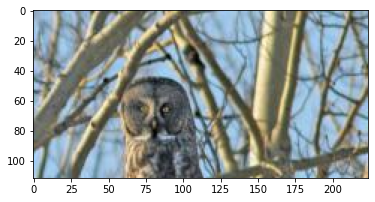

In [314]:
plt.imshow(img[:112,:,:])

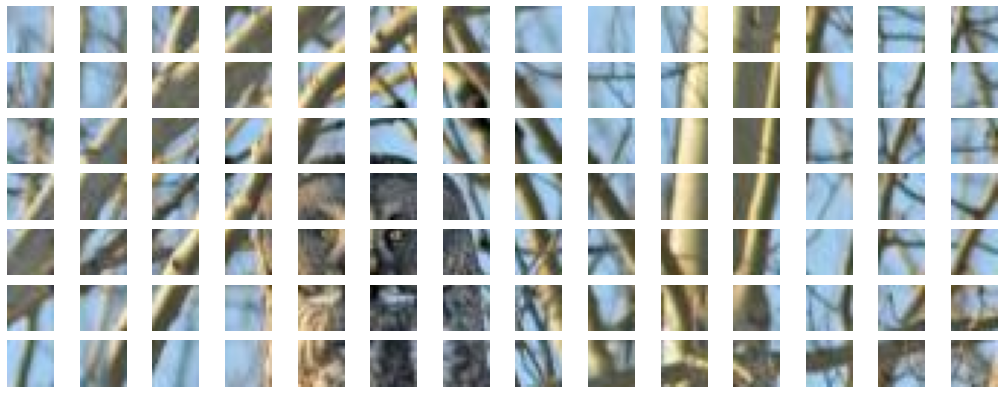

In [315]:
fig, axs = plt.subplots(nrows=7, ncols=14, figsize=(18, 7))
for i in range((grid_size * 7)):
    col_p = i // grid_size
    row_p = i - (col_p * grid_size)
    img_patch, coord = find_original_img_patch(i, img)
#     print(i, coord)
    axs[col_p, row_p].imshow(img_patch)    
    axs[col_p, row_p].axis('off')
    half_img[coord[0]:coord[1], coord[2]:coord[3], :] = img_patch

plt.show()    

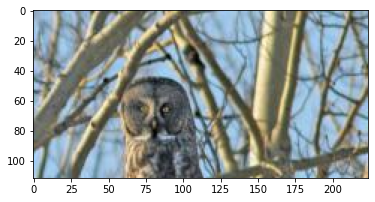

In [316]:
plt.imshow(half_img)

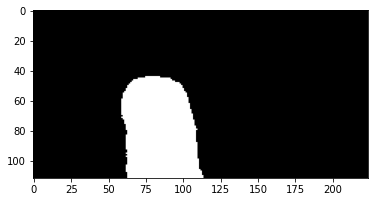

In [317]:
plt.imshow(mask_img[:112,:,:])

In [318]:
def is_patch_bg(original_img_mask, patch_coord, bg_threshold=.75):
    patch_with_mask = original_img_mask[patch_coord[0]:patch_coord[1], patch_coord[2]:patch_coord[3],:]
    perc_bg = len(patch_with_mask[patch_with_mask==0]) / 768
    return perc_bg > bg_threshold

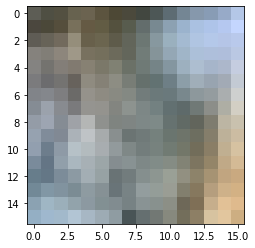

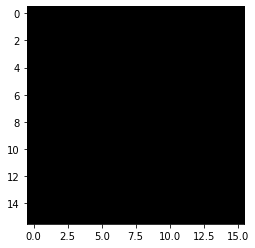

True
768


True

In [319]:
#patch where all pixels are BG
img_patch, coord = find_original_img_patch(97, img)
sample_patch = img[coord[0]:coord[1], coord[2]:coord[3], :]
sample_patch_mask = mask_img[coord[0]:coord[1], coord[2]:coord[3],:]
# sample_patch_mask = 

plt.imshow(sample_patch)
plt.show()
plt.imshow(sample_patch_mask)
plt.show()
print(np.all(sample_patch_mask == 0))
print(len(sample_patch_mask[sample_patch_mask==0]))
is_patch_bg(mask_img, coord)

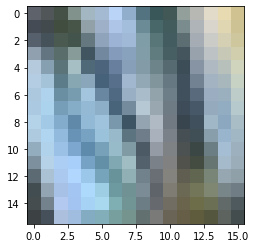

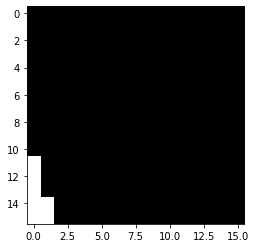

False
747
0.97265625


True

In [320]:
#patch where there are mixed pixels FG and BG
#
img_patch, coord = find_original_img_patch(91, img)
sample_patch = img[coord[0]:coord[1], coord[2]:coord[3], :]
sample_patch_mask = mask_img[coord[0]:coord[1], coord[2]:coord[3],:]
# sample_patch_mask = 

plt.imshow(sample_patch)
plt.show()
plt.imshow(sample_patch_mask)
plt.show()
print(np.all(sample_patch_mask == 0))
print(len(sample_patch_mask[sample_patch_mask==0]))
print(len(sample_patch_mask[sample_patch_mask==0])/768)
is_patch_bg(mask_img, coord, bg_threshold=0.5)

### Extracting relevant background tokens

Show attention map from last 3 layers with FG mask applied to a attention map

Use thresholding to figure if patch is BG.

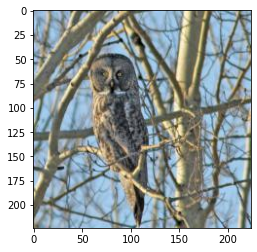

In [324]:
# segmentation_sample = np.load("IN9/bg_challenge/fg_mask/val/00_dog/n02088364_47125.npy")
# img = Image.open("IN9/bg_challenge/original/val/00_dog/n02088364_47125.JPEG").convert("RGB")
segmentation_sample = np.load("IN9/bg_challenge/fg_mask/val/01_bird/n01622779_16292.npy")
img = Image.open("IN9/bg_challenge/original/val/01_bird/n01622779_16292.JPEG").convert("RGB")
img = np.array(img)
mask_img = copy.deepcopy(img)
mask_img[~segmentation_sample] = 0
mask_img[segmentation_sample] = 255
plt.imshow(img)

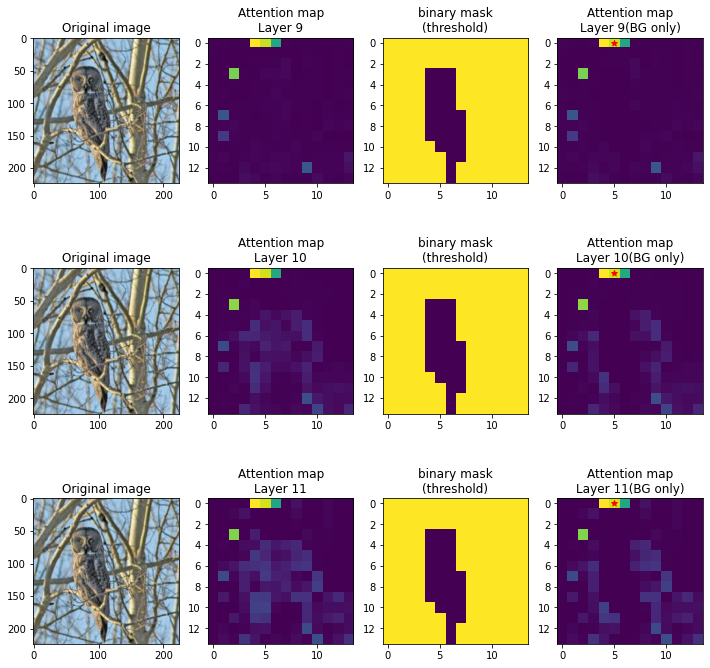

In [329]:
mean_map = att_map
grid_size = int(np.sqrt(mean_map[:,1:,1:].size(-1)))

fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(12, 12))
for idx, layer in enumerate(mean_map[-3:,:,:]):    
#     mask_patch = np.ones((196), dtype="bool")
    mask_patch_th = np.ones((196), dtype="bool")
    for patch in range(len(layer[0, 1:])):
        img_patch, coord = find_original_img_patch(patch, img)
#         mask_patch[patch] = np.all(mask_img[coord[0]:coord[1], coord[2]:coord[3],:] == 0)
        mask_patch_th[patch] = is_patch_bg(mask_img, coord)
        
    bg_token, _ = find_consistent_bg_token(mean_map, img, mask_img)
    
    axs[idx, 0].set_title("Original image")
    axs[idx, 0].imshow(img)
    img_map = copy.deepcopy(layer[0, 1:].detach().numpy())
    img_map = img_map.reshape(grid_size, grid_size)
    axs[idx, 1].set_title(f"Attention map\nLayer {9+idx}")
    axs[idx, 1].imshow(img_map)
#     mask_map = mask_patch.astype(int).reshape(grid_size, grid_size)
#     axs[idx, 1].set_title("binary mask")
#     axs[idx, 1].imshow(mask_map)
    mask_map_th = mask_patch_th.astype(int).reshape(grid_size, grid_size)
    axs[idx, 2].set_title("binary mask\n(threshold)")
    axs[idx, 2].imshow(mask_map_th)
    img_map_bg = copy.deepcopy(layer[0, 1:].detach().numpy())
    img_map_bg[~mask_patch_th] = 0
    img_map_bg = img_map_bg.reshape(grid_size, grid_size)
    axs[idx, 3].set_title(f"Attention map\nLayer {9+idx}(BG only)")
    axs[idx, 3].imshow(img_map_bg)
    col_p = bg_token // grid_size
    row_p = bg_token - (col_p * grid_size)
    axs[idx, 3].scatter(row_p, col_p, marker='*', c='red')
plt.show()

Find a background token that gets consistently top 5 attention weight (if there are multiple such cancidates, try top 3 or use the one with the maximum sum of attention over layers, if none in top 5, relax the condition till top 15).  

In [330]:
def find_consistent_bg_token(attention_map, original_img, original_bg_mask, n_layers=-3, min_n=3, max_n=20):
    all_top_n = []    
    for idx, layer in enumerate(attention_map[n_layers:, :, :]):    
        bg_mask_patch = np.ones((196), dtype="bool")
        for patch in range(len(layer[0, 1:])):
            img_patch, coord = find_original_img_patch(patch, original_img)
            bg_mask_patch[patch] = is_patch_bg(original_bg_mask, coord)

        # set all fg activation to 0
        img_map_bg = copy.deepcopy(layer[0, 1:].detach().numpy())
        img_map_bg[~bg_mask_patch] = 0

        # get top N activations of the layer    
        # based on https://stackoverflow.com/questions/6910641/how-do-i-get-indices-of-n-maximum-values-in-a-numpy-array
        top_n = np.argpartition(img_map_bg, -1 * max_n)[-1 * max_n:]
        top_n = top_n[np.argsort(img_map_bg[top_n])]
        top_n = top_n[::-1]
        all_top_n.append(top_n)    

    
    # find if there's intersection with previous layer
    for n in range(min_n, max_n, 2):
        common_tokens = set()
        for layer_no, layer_top_n in enumerate(all_top_n):
            if layer_no==0:
                common_tokens = set(layer_top_n[:n])                
            else:
                common_tokens = common_tokens.intersection(set(layer_top_n[:n]))
                if not common_tokens:
                    print(f"No common token with top {n}")
                    break
        if common_tokens:
#             print(f"found common tokens with top {n}")
            bg_token = list(common_tokens)
            if len(bg_token)>1:
                # sum selected tokens across all layers to get top 1
                sums = dict(zip(bg_token, [0] * len(bg_token)))
                for layer in attention_map[n_layers:, :, :]:
                    for token in bg_token:
                        sums[token] += layer[0, token].detach().numpy()
#                 print(sums)
                bg_token = max(sums, key=sums.get)
#                 print(bg_token)
            else:
                bg_token = bg_token[0]
            break
            
    return bg_token, all_top_n


In [332]:
token, _ = find_consistent_bg_token(mean_map, img, mask_img)
token

5

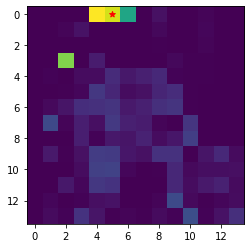

In [333]:
plt.imshow(mean_map[-1,0,1:].detach().numpy().reshape(grid_size, grid_size))
col_p = token // grid_size
row_p = token - (col_p * grid_size)
plt.scatter(row_p, col_p, marker='*', c='red')

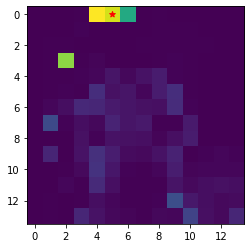

In [334]:
plt.imshow(mean_map[-2,0,1:].detach().numpy().reshape(grid_size, grid_size))
col_p = token // grid_size
row_p = token - (col_p * grid_size)
plt.scatter(row_p, col_p, marker='*', c='red')

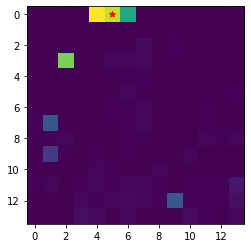

In [335]:
plt.imshow(mean_map[-3,0,1:].detach().numpy().reshape(grid_size, grid_size))
col_p = token // grid_size
row_p = token - (col_p * grid_size)
plt.scatter(row_p, col_p, marker='*', c='red')

### Extracting activation of selected token

Activation of token T in layer N, i.e the output of the layer for that token.

In [337]:
token, _ = find_consistent_bg_token(mean_map, img, mask_img)
token

5

In [76]:
def extract_bg_token(img: Image.Image, mask:np.array, transform, renorm_weights=True):
    x = transform(img)
    logits, att_map, layer_activations = model(x.unsqueeze(0))
    att_map = torch.stack(att_map)
    att_map = att_map.squeeze(1)

    # Average the attention weights across all heads.
    att_map = torch.mean(att_map, dim=1)
    mean_att_map = att_map
    
    grid_size = int(np.sqrt(mean_att_map[:,1:,1:].size(-1)))
    
    if renorm_weights:
        residual_att = torch.eye(mean_att_map.size(1))
        aug_mean_map = mean_att_map + residual_att
        aug_mean_map = aug_mean_map / aug_mean_map.sum(dim=-1).unsqueeze(-1)
        mean_att_map = aug_mean_map
        
    mask_img = copy.deepcopy(np.array(img))
    mask_img[~mask] = 0
    mask_img[mask] = 255
        
    selected_token, _ = find_consistent_bg_token(mean_att_map, np.array(img), mask_img)
    
    return selected_token, mean_att_map, layer_activations

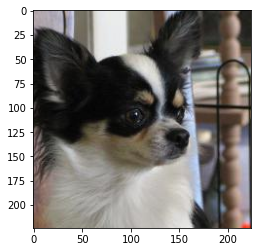

In [77]:
segmentation_sample = np.load("IN9/bg_challenge/fg_mask/val/00_dog/n02085620_16757.npy")
img = Image.open("IN9/bg_challenge/original/val/00_dog/n02085620_16757.JPEG").convert("RGB")
plt.imshow(img)

In [78]:
token, att_map, activations = extract_bg_token(img, segmentation_sample, transform)
token

found common tokens with top 3


34

In [49]:
att_map.shape

torch.Size([12, 197, 197])

In [84]:
last_act = activations[-1].squeeze().detach().numpy()
last_act[token,:]

array([ 5.66800117e+00, -1.28873377e+01, -3.02532554e+00, -3.85087681e+00,
        1.79923058e+01,  5.32922268e-01,  6.41126728e+00,  2.23010039e+00,
       -8.61813354e+00,  4.86499691e+00,  1.32530899e+01,  3.66311836e+00,
        4.69121552e+00, -9.58989429e+00, -2.17501736e+00,  7.62478304e+00,
       -8.86860752e+00,  1.15217896e+01, -4.84948349e+00, -2.24750423e+00,
       -2.14690208e+01,  2.11754093e+01, -4.33750248e+00,  1.34391441e+01,
       -5.34204769e+00, -1.00149345e+01, -5.83965492e+00,  4.83508015e+00,
        1.14246941e+01,  8.93675423e+00,  1.04506149e+01,  4.16267300e+00,
       -2.52465153e+00, -5.10363579e+00, -3.89234018e+00, -1.32615900e+01,
       -1.90319519e+01, -2.92448330e+00,  4.11369324e+00,  1.18785267e+01,
        1.66438980e+01, -6.41534805e+00,  1.68430233e+01,  6.70914268e+00,
       -9.36788177e+00,  1.83537216e+01, -6.48634672e-01,  6.50275803e+00,
       -3.70292377e+00,  1.32758379e-01,  8.73977375e+00, -2.26997542e+00,
       -6.44716167e+00, -

### Creating a dataset

From SUN397 dataset:
* classes: grass, sky, tree, water, rocks
* Selected classes from IN9 and replace background with one from SUN (just copy pixels from SUN to BG in IN9)

**This way we know true class of BG**

## Extract features

* apply `find_consistent_bg_token` 
* get the output from that token
* save it for training a clf

In [225]:
import pandas as pd
from tqdm import tqdm

In [226]:
features = {"image_filename": [], 
           "mask_filename": [],
           "bg_token": [],
           "layer_11_act": [],
           "layer_10_act": [],
           "layer_09_act": [],
           "class": []}

In [227]:
# iterate over created dataset
# LIMIT = 300
BG_IN9_BASE_DIR = "data/IN9_SUN_BG"
IN9_BASE_MASK_DIR = "IN9/bg_challenge/fg_mask/val/"
classes = os.listdir(BG_IN9_BASE_DIR)
classes = classes[:5]

In [228]:
for cls in classes:
    img_filenames = os.listdir(os.path.join(BG_IN9_BASE_DIR, cls))
    for img_file in tqdm(img_filenames):
        img = Image.open(os.path.join(BG_IN9_BASE_DIR, cls, img_file)).convert("RGB")
        mask_file = img_file[:-4] + "npy"
        mask = np.load(os.path.join(IN9_BASE_MASK_DIR, cls[:cls.rfind("_")], mask_file))
        token, att_map, activations = extract_bg_token(img, mask, transform)
        features["image_filename"].append(os.path.join(BG_IN9_BASE_DIR, cls, img_file))
        features["mask_filename"].append(os.path.join(BG_IN9_BASE_DIR, cls, mask_file))
        features["bg_token"].append(token)
        features["layer_11_act"].append(activations[11].squeeze().detach().numpy()[token,:])
        features["layer_10_act"].append(activations[10].squeeze().detach().numpy()[token,:])
        features["layer_09_act"].append(activations[9].squeeze().detach().numpy()[token,:])
        features["class"].append(cls[cls.rfind("_")+1:])

  8%|██████▌                                                                           | 36/450 [00:14<02:53,  2.39it/s]

No common token with top 3


 30%|████████████████████████                                                         | 134/450 [00:56<02:16,  2.32it/s]

No common token with top 3


 33%|██████████████████████████▊                                                      | 149/450 [01:03<02:10,  2.31it/s]

No common token with top 3
No common token with top 5
No common token with top 7
No common token with top 9
No common token with top 11


 41%|█████████████████████████████████▎                                               | 185/450 [01:18<01:54,  2.31it/s]

No common token with top 3


 43%|██████████████████████████████████▋                                              | 193/450 [01:22<01:50,  2.32it/s]

No common token with top 3


 52%|██████████████████████████████████████████▍                                      | 236/450 [01:41<01:32,  2.31it/s]

No common token with top 3


 60%|████████████████████████████████████████████████▊                                | 271/450 [01:56<01:17,  2.31it/s]

No common token with top 3


 72%|██████████████████████████████████████████████████████████▋                      | 326/450 [02:19<00:52,  2.35it/s]

No common token with top 3


  2%|██                                                                                | 11/450 [00:04<03:07,  2.34it/s]

No common token with top 3
No common token with top 5


 16%|████████████▉                                                                     | 71/450 [00:30<02:43,  2.32it/s]

No common token with top 3


 36%|████████████████████████████▉                                                    | 161/450 [01:09<02:04,  2.33it/s]

No common token with top 3
No common token with top 5


 40%|████████████████████████████████▏                                                | 179/450 [01:17<01:57,  2.30it/s]

No common token with top 3


 92%|██████████████████████████████████████████████████████████████████████████▉      | 416/450 [02:59<00:14,  2.32it/s]

No common token with top 3


 95%|████████████████████████████████████████████████████████████████████████████▋    | 426/450 [03:03<00:10,  2.31it/s]

No common token with top 3
No common token with top 5


  4%|███▋                                                                              | 20/450 [00:08<03:04,  2.33it/s]

No common token with top 3
No common token with top 5
No common token with top 7


 30%|████████████████████████                                                         | 134/450 [00:57<02:16,  2.31it/s]

No common token with top 3
No common token with top 5


 33%|██████████████████████████▊                                                      | 149/450 [01:04<02:09,  2.32it/s]

No common token with top 3
No common token with top 5
No common token with top 7
No common token with top 9
No common token with top 11
No common token with top 13


 36%|████████████████████████████▊                                                    | 160/450 [01:09<02:04,  2.34it/s]

No common token with top 3


 55%|████████████████████████████████████████████▍                                    | 247/450 [01:46<01:28,  2.29it/s]

No common token with top 3
No common token with top 5


 57%|█████████████████████████████████████████████▉                                   | 255/450 [01:49<01:23,  2.34it/s]

No common token with top 3


 63%|███████████████████████████████████████████████████                              | 284/450 [02:02<01:12,  2.30it/s]

No common token with top 3


 82%|██████████████████████████████████████████████████████████████████▊              | 371/450 [02:39<00:33,  2.35it/s]

No common token with top 3


 92%|██████████████████████████████████████████████████████████████████████████▉      | 416/450 [02:59<00:14,  2.31it/s]

No common token with top 3


  5%|████▎                                                                             | 24/450 [00:10<03:02,  2.34it/s]

No common token with top 3
No common token with top 5
No common token with top 7
No common token with top 9
No common token with top 11
No common token with top 13
No common token with top 15
No common token with top 17


 22%|██████████████████                                                               | 100/450 [00:44<02:30,  2.33it/s]

No common token with top 3
No common token with top 5
No common token with top 7
No common token with top 9
No common token with top 11


 33%|██████████████████████████▊                                                      | 149/450 [01:08<02:10,  2.31it/s]

No common token with top 3
No common token with top 5


 52%|█████████████████████████████████████████▉                                       | 233/450 [01:49<01:41,  2.13it/s]

No common token with top 3
No common token with top 5


 82%|██████████████████████████████████████████████████████████████████▊              | 371/450 [02:58<00:34,  2.29it/s]

No common token with top 3


 86%|█████████████████████████████████████████████████████████████████████▎           | 385/450 [03:04<00:27,  2.32it/s]

No common token with top 3


  4%|███▎                                                                              | 18/450 [00:07<03:06,  2.32it/s]

No common token with top 3


  5%|████▎                                                                             | 24/450 [00:10<03:04,  2.31it/s]

No common token with top 3
No common token with top 5
No common token with top 7
No common token with top 9
No common token with top 11
No common token with top 13


 17%|██████████████▏                                                                   | 78/450 [00:33<02:40,  2.32it/s]

No common token with top 3
No common token with top 5


 33%|██████████████████████████▊                                                      | 149/450 [01:04<02:09,  2.33it/s]

No common token with top 3
No common token with top 5
No common token with top 7
No common token with top 9


 38%|██████████████████████████████▉                                                  | 172/450 [01:14<02:01,  2.30it/s]

No common token with top 3


 52%|█████████████████████████████████████████▉                                       | 233/450 [01:40<01:33,  2.32it/s]

No common token with top 3


 57%|██████████████████████████████████████████████▍                                  | 258/450 [01:51<01:22,  2.34it/s]

No common token with top 3
No common token with top 5
No common token with top 7
No common token with top 9
No common token with top 11


 58%|██████████████████████████████████████████████▊                                  | 260/450 [01:52<01:22,  2.30it/s]

No common token with top 3


 70%|█████████████████████████████████████████████████████████                        | 317/450 [02:17<00:57,  2.30it/s]

No common token with top 3
No common token with top 5
No common token with top 7


100%|█████████████████████████████████████████████████████████████████████████████████| 450/450 [03:09<00:00,  2.37it/s]


In [229]:
labels = ['water', 'grass', 'sky', 'tree', 'rock']
labels_to_idx = dict(zip(labels, range(len(labels))))
labels_to_idx

{'water': 0, 'grass': 1, 'sky': 2, 'tree': 3, 'rock': 4}

In [230]:
feat_pd = pd.DataFrame(features)
feat_pd["labels"] = feat_pd['class'].apply(lambda x: labels_to_idx[x])
print(feat_pd.shape)
feat_pd.head()

(2250, 8)


,image_filename,mask_filename,bg_token,layer_11_act,layer_10_act,layer_09_act,class,labels
0,data/IN9_SUN_BG/00_dog_grass/n02085620_16757.JPEG,data/IN9_SUN_BG/00_dog_grass/n02085620_16757.npy,6,"[-0.28059238, -11.9229145, 3.651448, 6.4630456...","[3.5011632, -6.3560114, 1.8273182, 1.2355998, ...","[0.7859965, -9.565547, 4.237654, 0.6370287, -2...",grass,1
1,data/IN9_SUN_BG/00_dog_grass/n02085620_28943.JPEG,data/IN9_SUN_BG/00_dog_grass/n02085620_28943.npy,172,"[2.6938243, -11.496307, -0.9284701, -0.227602,...","[4.3707867, -12.210199, -1.9234052, -1.1596222...","[2.3743062, -16.91092, 0.3471825, -2.1008458, ...",grass,1
2,data/IN9_SUN_BG/00_dog_grass/n02085620_37791.JPEG,data/IN9_SUN_BG/00_dog_grass/n02085620_37791.npy,24,"[-1.7790769, -11.335104, 2.5069082, 0.06748193...","[1.873951, -11.207916, 0.82363224, -0.58587813...","[-0.038787425, -15.000303, 2.648239, -1.056847...",grass,1
3,data/IN9_SUN_BG/00_dog_grass/n02085620_49159.JPEG,data/IN9_SUN_BG/00_dog_grass/n02085620_49159.npy,27,"[-3.0692677, 2.737633, -1.2040347, -5.9740677,...","[-0.8107995, 1.6725023, -2.9748304, -1.0450131...","[-0.758996, 1.9339439, -3.364693, -0.859401, -...",grass,1
4,data/IN9_SUN_BG/00_dog_grass/n02085782_14911.JPEG,data/IN9_SUN_BG/00_dog_grass/n02085782_14911.npy,7,"[-2.4097946, -7.957181, 0.486215, 2.359203, -3...","[-0.15609121, -7.7119684, -1.2815412, 0.420939...","[-2.047585, -12.088235, 1.4373269, -1.1656969,...",grass,1


In [231]:
# !pip install scikit-learn

In [232]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

In [233]:
data = feat_pd["layer_11_act"].values.tolist()
labels = to_categorical(feat_pd["labels"].values.tolist())

In [338]:
print(len(data))
data[0].shape

2250


(768,)

In [235]:
print(len(labels))
labels[0]

2250


array([0., 1., 0., 0., 0.], dtype=float32)

In [236]:
def base_model():
    clf_model = Sequential()
    clf_model.add(Dense(256, input_dim=768, activation='relu'))
    clf_model.add(Dropout(0.5))
    clf_model.add(Dense(5))
    clf_model.add(Activation("softmax"))

#     sgd = SGD(lr=0.001)
    adam = Adam()
    clf_model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=["accuracy"])
    return clf_model

In [240]:
layers = ['layer_11_act', 'layer_10_act', 'layer_09_act']
histories = {}
test_scores = {}
for layer in layers:
    data = feat_pd[layer].values.tolist()
    train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.10, random_state=42, 
                                                                        shuffle=True)    
    clf_model = base_model()
    hist = clf_model.fit(tf.stack(train_data), 
                         tf.stack(train_labels), 
                         validation_split=0.10,
                         epochs=100, 
                         batch_size=128, 
                         verbose=1)
    histories[layer] = hist
    test_scores[layer] = clf_model.evaluate(tf.stack(test_data), tf.stack(test_labels), batch_size=len(test_data))

Epoch 1/100
15/15 [==============================] - 0s 9ms/step - loss: 59.1608 - accuracy: 0.2448 - val_loss: 15.3073 - val_accuracy: 0.4631
Epoch 2/100
15/15 [==============================] - 0s 4ms/step - loss: 26.5108 - accuracy: 0.4182 - val_loss: 7.8946 - val_accuracy: 0.5468
Epoch 3/100
15/15 [==============================] - 0s 4ms/step - loss: 7.8627 - accuracy: 0.5505 - val_loss: 2.3522 - val_accuracy: 0.6207
Epoch 4/100
15/15 [==============================] - 0s 4ms/step - loss: 2.0024 - accuracy: 0.6394 - val_loss: 1.4810 - val_accuracy: 0.6700
Epoch 5/100
15/15 [==============================] - 0s 4ms/step - loss: 1.1767 - accuracy: 0.6520 - val_loss: 1.4427 - val_accuracy: 0.6798
Epoch 6/100
15/15 [==============================] - 0s 5ms/step - loss: 0.9327 - accuracy: 0.6981 - val_loss: 1.3350 - val_accuracy: 0.6995
Epoch 7/100
15/15 [==============================] - 0s 4ms/step - loss: 0.8709 - accuracy: 0.7168 - val_loss: 1.3527 - val_accuracy: 0.6700
Epoch 8/10

Epoch 59/100
15/15 [==============================] - 0s 4ms/step - loss: 0.2387 - accuracy: 0.9034 - val_loss: 1.2177 - val_accuracy: 0.7635
Epoch 60/100
15/15 [==============================] - 0s 4ms/step - loss: 0.2781 - accuracy: 0.8963 - val_loss: 1.2118 - val_accuracy: 0.7537
Epoch 61/100
15/15 [==============================] - 0s 4ms/step - loss: 0.2438 - accuracy: 0.8974 - val_loss: 1.1848 - val_accuracy: 0.7586
Epoch 62/100
15/15 [==============================] - 0s 4ms/step - loss: 0.2293 - accuracy: 0.9127 - val_loss: 1.1633 - val_accuracy: 0.7389
Epoch 63/100
15/15 [==============================] - 0s 4ms/step - loss: 0.2157 - accuracy: 0.9193 - val_loss: 1.1727 - val_accuracy: 0.7635
Epoch 64/100
15/15 [==============================] - 0s 5ms/step - loss: 0.2439 - accuracy: 0.8963 - val_loss: 1.1975 - val_accuracy: 0.7586
Epoch 65/100
15/15 [==============================] - 0s 4ms/step - loss: 0.2469 - accuracy: 0.9067 - val_loss: 1.1711 - val_accuracy: 0.7438
Epoch 

15/15 [==============================] - 0s 4ms/step - loss: 0.6100 - accuracy: 0.7536 - val_loss: 1.2845 - val_accuracy: 0.6108
Epoch 17/100
15/15 [==============================] - 0s 4ms/step - loss: 0.6152 - accuracy: 0.7503 - val_loss: 1.2348 - val_accuracy: 0.6355
Epoch 18/100
15/15 [==============================] - 0s 4ms/step - loss: 0.5852 - accuracy: 0.7602 - val_loss: 1.2433 - val_accuracy: 0.6502
Epoch 19/100
15/15 [==============================] - 0s 4ms/step - loss: 0.5801 - accuracy: 0.7706 - val_loss: 1.2586 - val_accuracy: 0.6700
Epoch 20/100
15/15 [==============================] - 0s 4ms/step - loss: 0.5995 - accuracy: 0.7618 - val_loss: 1.2435 - val_accuracy: 0.6404
Epoch 21/100
15/15 [==============================] - 0s 4ms/step - loss: 0.5748 - accuracy: 0.7695 - val_loss: 1.2626 - val_accuracy: 0.6650
Epoch 22/100
15/15 [==============================] - 0s 4ms/step - loss: 0.5609 - accuracy: 0.7602 - val_loss: 1.2455 - val_accuracy: 0.6502
Epoch 23/100
15/15 

Epoch 74/100
15/15 [==============================] - 0s 3ms/step - loss: 0.4137 - accuracy: 0.8260 - val_loss: 1.1968 - val_accuracy: 0.7241
Epoch 75/100
15/15 [==============================] - 0s 3ms/step - loss: 0.4272 - accuracy: 0.8150 - val_loss: 1.2480 - val_accuracy: 0.6847
Epoch 76/100
15/15 [==============================] - 0s 3ms/step - loss: 0.4127 - accuracy: 0.8321 - val_loss: 1.2349 - val_accuracy: 0.7143
Epoch 77/100
15/15 [==============================] - 0s 3ms/step - loss: 0.4253 - accuracy: 0.8205 - val_loss: 1.2295 - val_accuracy: 0.7094
Epoch 78/100
15/15 [==============================] - 0s 3ms/step - loss: 0.3899 - accuracy: 0.8458 - val_loss: 1.1934 - val_accuracy: 0.7241
Epoch 79/100
15/15 [==============================] - 0s 3ms/step - loss: 0.3902 - accuracy: 0.8326 - val_loss: 1.1767 - val_accuracy: 0.7340
Epoch 80/100
15/15 [==============================] - 0s 3ms/step - loss: 0.3453 - accuracy: 0.8650 - val_loss: 1.2123 - val_accuracy: 0.7291
Epoch 

15/15 [==============================] - 0s 4ms/step - loss: 0.5575 - accuracy: 0.7662 - val_loss: 1.2575 - val_accuracy: 0.6108
Epoch 32/100
15/15 [==============================] - 0s 3ms/step - loss: 0.5755 - accuracy: 0.7525 - val_loss: 1.2427 - val_accuracy: 0.6158
Epoch 33/100
15/15 [==============================] - 0s 3ms/step - loss: 0.5660 - accuracy: 0.7602 - val_loss: 1.2846 - val_accuracy: 0.6453
Epoch 34/100
15/15 [==============================] - 0s 3ms/step - loss: 0.5879 - accuracy: 0.7503 - val_loss: 1.3099 - val_accuracy: 0.6207
Epoch 35/100
15/15 [==============================] - 0s 3ms/step - loss: 0.5647 - accuracy: 0.7552 - val_loss: 1.3065 - val_accuracy: 0.6059
Epoch 36/100
15/15 [==============================] - 0s 4ms/step - loss: 0.5809 - accuracy: 0.7486 - val_loss: 1.2889 - val_accuracy: 0.6256
Epoch 37/100
15/15 [==============================] - 0s 4ms/step - loss: 0.5389 - accuracy: 0.7651 - val_loss: 1.2440 - val_accuracy: 0.6453
Epoch 38/100
15/15 

Epoch 89/100
15/15 [==============================] - 0s 3ms/step - loss: 0.4111 - accuracy: 0.8216 - val_loss: 1.3079 - val_accuracy: 0.6847
Epoch 90/100
15/15 [==============================] - 0s 4ms/step - loss: 0.3955 - accuracy: 0.8249 - val_loss: 1.3019 - val_accuracy: 0.6847
Epoch 91/100
15/15 [==============================] - 0s 4ms/step - loss: 0.3801 - accuracy: 0.8364 - val_loss: 1.2713 - val_accuracy: 0.6847
Epoch 92/100
15/15 [==============================] - 0s 4ms/step - loss: 0.3925 - accuracy: 0.8277 - val_loss: 1.3346 - val_accuracy: 0.6847
Epoch 93/100
15/15 [==============================] - 0s 4ms/step - loss: 0.4209 - accuracy: 0.8139 - val_loss: 1.2953 - val_accuracy: 0.6995
Epoch 94/100
15/15 [==============================] - 0s 4ms/step - loss: 0.3806 - accuracy: 0.8282 - val_loss: 1.3282 - val_accuracy: 0.7044
Epoch 95/100
15/15 [==============================] - 0s 4ms/step - loss: 0.3719 - accuracy: 0.8364 - val_loss: 1.3276 - val_accuracy: 0.6749
Epoch 

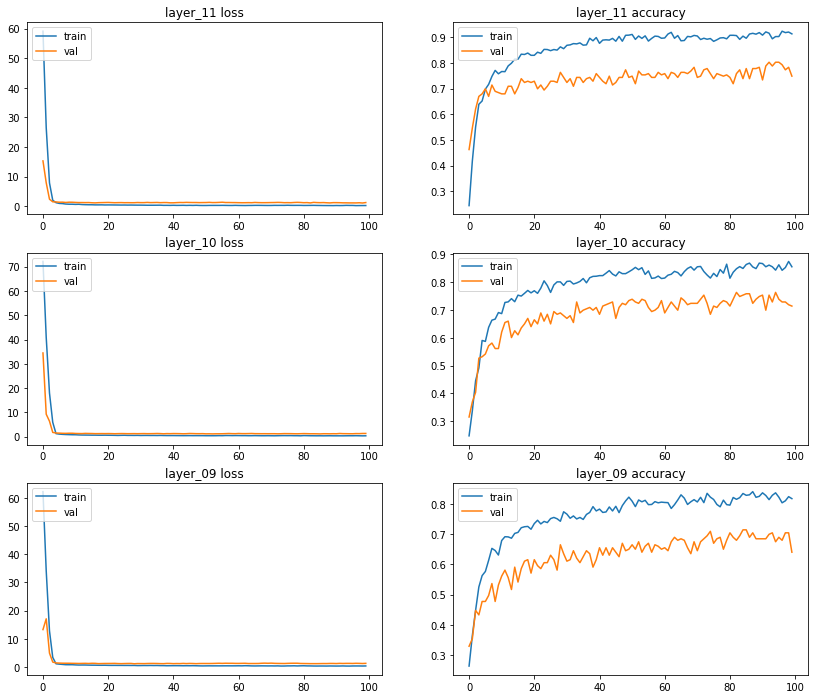

In [241]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(14, 12))
for idx, (layer_name, hist) in enumerate(histories.items()):
    axs[idx, 0].plot(hist.history['loss'])
    axs[idx, 0].plot(hist.history['val_loss'])
    axs[idx, 0].set_title(f'{layer_name[:-4]} loss')
#     axs[idx, 0].ylabel('loss')
#     axs[idx, 0].xlabel('epoch')
    axs[idx, 0].legend(['train', 'val'], loc='upper left')

    axs[idx, 1].plot(hist.history['accuracy'])
    axs[idx, 1].plot(hist.history['val_accuracy'])
    axs[idx, 1].set_title(f'{layer_name[:-4]} accuracy')
#     axs[idx, 1].ylabel('accuracy')
#     axs[idx, 1].xlabel('epoch')
    axs[idx, 1].legend(['train', 'val'], loc='upper left')

plt.show()

In [239]:
test_scores

{'layer_11_act': [1.017206072807312, 0.7644444704055786],
 'layer_10_act': [1.3187994956970215, 0.7066666483879089],
 'layer_09_act': [0.9095414876937866, 0.7511110901832581]}

| Layer | Test loss | Test accuracy |
|---|---|------|
| 9 | 0.9095 | **0.764**   |
| 10 | 1.3187 | 0.706    |
| 11 | 1.0172 | 0.751    |